# Investigate Type-I Error Control

Suppose both data and trained synthetic generators are available already

In [1]:
import torch


import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import quantile_transform
from scipy.stats import norm

from lightning.pytorch import seed_everything

import time
from copy import deepcopy
import os
import shutil
from tqdm import tqdm
import json
import pickle

import seaborn as sns
import matplotlib.pyplot as plt


from sample import TrueSampler

import sys

In [2]:
class PathConfig:
    tddpm_dir: str = "/home/liu00980/Documents/multimodal/tabular/tab-ddpm/"
    syninf_dir: str = (
        "/home/liu00980/Documents/multimodal/tabular/tab-ddpm/pass-inference/syninf"
    )


pathconfig = PathConfig()


class ExpConfig:
    n_train: int = 1000
    n_inf: int = 200
    sigma: float = 0.2
    keyword: str = "inf_10000"

    null_features_list: list = ["num_7"]
    rho: float = 10
    D: int = 1000
    
    alpha: float = 0.05
    epsilon: float = 0.01

    cache_dir: str = "./temp/"
    cache_dir_spare: str = "./temp2/"

    cuda_id: int = 7
    seed: int = 2023

    """
    - n_train, n_inf: sizes of raw training sample and inference sample
    - keyword: indicates pre-training size
    - null_features_list: features to be tested
    - rho: synthetic-to-raw ratio
    - D: MC size for Syn-Test
    - cache_dir, cache_dir_spare: temporary directories for saving intermediate results. e.g. one for twin_1 and another one for twin_2
    """

    def __init__(self):
        self.ckpt_dir = f"./ckpt/{self.keyword}"
        self.raw_data_dir = os.path.join(pathconfig.tddpm_dir, f"data/inf_raw")
        
        suffix = "_".join(self.null_features_list)
        self.result_dict_save_path = f"./results/inf/result_dict_{suffix}.pkl"
        self.raw_result_dict_save_path = f"./results/inf/raw_result_dict_{suffix}.pkl"
        

expconfig = ExpConfig()


class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [3]:
torch.cuda.set_device(expconfig.cuda_id)

sys.path.insert(0, pathconfig.syninf_dir)
from utils_syninf import (
    train_tabddpm,
    generate_sample,
    concat_data,
    catboost_pred_model,
    blackbox_test_stat,
    combine_Hommel,
)
from utils_num import wasserstein_2_distance
from utils_viz import compare_distributions_grid, heatmap_correlation

In [4]:
def get_p_values(null_ecdf, t_null_ecdf, direction = "greater"):
    """
    Get P-values based on one reference null distribution and a distribution of the test statistic under H0
    - null_ecdf: empirical CDF of the reference null distribution, used to get p-values
    - t_null_ecdf: empirical CDF of the test statistic under H0
    """
    if direction == "greater":
        p_values = [np.mean(null_ecdf >= t) for t in t_null_ecdf]
    elif direction == "less":
        p_values = [np.mean(null_ecdf <= t) for t in t_null_ecdf]
    elif direction == "two-sided":
        p_values = [2 * min(np.mean(null_ecdf >= t), np.mean(null_ecdf <= t)) for t in t_null_ecdf]
    
    return p_values


def soft_type_i(p_values, alpha = 0.05, epsilon = 0.01):
    """
    Type-I error rate with soft thresholding based on p-values
    - p_values: p-values obtained under the null hypothesis
    """
    type_i_error = np.mean(np.array(p_values) <= alpha - epsilon)
    return type_i_error


def soft_type_i_errors(result_dict, direction = "greater", alpha = 0.05, epsilon = 0.01):
    """
    Type-I errors w.r.t. synthetic-to-raw ratio based on result_dict.
    """
    rho_list, type_i_error_list = [], []
    for rho_str in result_dict.keys():
        p_values_twin_1 = get_p_values(
            np.array(result_dict[rho_str]["twin_1"]["test_stat_null"]),
            np.array(result_dict[rho_str]["twin_2"]["test_stat_null"]),
            direction = direction,
        )
        p_values_twin_2 = get_p_values(
            np.array(result_dict[rho_str]["twin_2"]["test_stat_null"]),
            np.array(result_dict[rho_str]["twin_1"]["test_stat_null"]),
            direction = direction
        )
        p_values_combined = [combine_Hommel([p1, p2]) for p1, p2 in zip(p_values_twin_1, p_values_twin_2)]
        
        rho_list.append(float(rho_str))
        type_i_error_list.append(soft_type_i(p_values_combined, alpha = alpha, epsilon = epsilon))
    
    return rho_list, type_i_error_list, p_values_combined
        


## Synthetic versus synthetic null

In [5]:
# Configurations for Syn-Test

# kwargs for training CatBoost model
cb_kwargs = {
    "num_features_list": [f"num_{i}" for i in range(8)],
    "iterations": 2000,
    "loss_function": "MAE",
    "verbose": False,
}


# kwargs for generating samples using twin generators
tddpm_kwargs_twin = {
    twin_kw: {
        "pipeline_config_path": f"./ckpt/{expconfig.keyword}_{twin_kw}/config.toml",
        "ckpt_path": f"./ckpt/{expconfig.keyword}_{twin_kw}/model.pt",
        "pipeline_dict_path": os.path.join(
            expconfig.ckpt_dir, "pipeline_dict.joblib"
        ),  # same as the pre-processing pipeline during its fine-tuning
        "temp_parent_dir": expconfig.cache_dir if twin_kw == "twin_1" else expconfig.cache_dir_spare,
        "device": f"cuda:{expconfig.cuda_id}",
    }
    for twin_kw in ["twin_1", "twin_2"]
}

In [6]:
# Generate synthetic sample ONCE AND FOR ALL for twin folders

regenerate = False  # whether to regenerate synthetic samples

if regenerate:
    seed_everything(expconfig.seed)

    for twin_kw in ["twin_1", "twin_2"]:
        temp_sample_kwargs = deepcopy(tddpm_kwargs_twin[twin_kw])
        temp_sample_kwargs["temp_parent_dir"] = f"./ckpt/{expconfig.keyword}_{twin_kw}/"

        print("Generating synthetic samples for", twin_kw)

        m = 20 * expconfig.n_inf  # rho_max = 20
        generate_sample(
            num_samples=int(expconfig.D * m),
            batch_size=int(expconfig.D * m / 10),
            seed=random.randint(0, 100000),
            **temp_sample_kwargs,
        )
        print("Synthetic sample saved at", temp_sample_kwargs["temp_parent_dir"])
else:
    df_twin_1 = concat_data(f"./ckpt/{expconfig.keyword}_twin_1/")
    print("Size for twin_1:", df_twin_1.shape)
    df_twin_2 = concat_data(f"./ckpt/{expconfig.keyword}_twin_2/")
    print("Size for twin_2:", df_twin_2.shape)

Size for twin_1: (4000000, 9)
Size for twin_2: (4000000, 9)


**Interesting observation:** when using raw sample to train f* and g*, we are able to control Type-I error, I guess training regressor on synthetic data and validate on raw data didn't work as properly or is too sensitive?

In [7]:
# Get f* and g* for constructing test statistic
# (cont.) use synthetic sample for training and raw sample for validation

seed_everything(expconfig.seed)

# generate_sample(
#     num_samples=10 * expconfig.n_train,
#     batch_size=10 * expconfig.n_train,
#     seed=random.randint(0, 100000),
#     **tddpm_kwargs_twin["twin_1"]
# )
# df_train = concat_data(tddpm_kwargs_twin["twin_1"]["temp_parent_dir"], split="train")



# df_raw_train = concat_data(expconfig.raw_data_dir, split="train")
# df_raw_val = concat_data(expconfig.raw_data_dir, split="val")
# df_raw_all = pd.concat([df_raw_train, df_raw_val], axis=0)


df_train = concat_data(expconfig.raw_data_dir, split="train")
df_raw_all = concat_data(expconfig.raw_data_dir, split="val")

model_full = catboost_pred_model(df_train, df_raw_all, **cb_kwargs)
model_partial = catboost_pred_model(
    df_train, df_raw_all, null_features_list=expconfig.null_features_list, **cb_kwargs
)


print("Full model:", model_full.best_score_)
print("Partial model:", model_partial.best_score_)

Seed set to 2023


no null features, using all specified features for training
null features ['num_7'] will be removed during training
Full model: {'learn': {'MAE': 0.0564045015070008}, 'validation': {'MAE': 0.17414687817091415}}
Partial model: {'learn': {'MAE': 0.058901757077719226}, 'validation': {'MAE': 0.17477284561280093}}


In [98]:
# get null distribution of the test statistic
m = expconfig.rho * expconfig.n_inf

result_dict = {
    "n_inf": expconfig.n_inf,
    "rho": expconfig.rho,
    "m": m,
}

seed_everything(expconfig.seed)

for twin_kw in ["twin_1", "twin_2"]:
    print("Processing", twin_kw)

    df_twin = df_twin_1 if twin_kw == "twin_1" else df_twin_2
    test_stat_list, test_stat_null_list = [], []
    for d in tqdm(range(expconfig.D)):
        temp_df = df_twin.iloc[d * m : (d + 1) * m].copy()
        test_stat = blackbox_test_stat(
            temp_df,
            model_full,
            model_partial,
            null_feature_names=expconfig.null_features_list,
            **cb_kwargs
        )
        test_stat_list.append(test_stat)

        temp_df_null = temp_df.copy()
        temp_df_null[expconfig.null_features_list] = np.random.rand(
            temp_df_null.shape[0], len(expconfig.null_features_list)
        )
        test_stat_null = blackbox_test_stat(
            temp_df_null,
            model_full,
            model_partial,
            null_feature_names=expconfig.null_features_list,
            **cb_kwargs
        )
        test_stat_null_list.append(test_stat_null)

    result_dict[twin_kw] = {
        "test_stat": test_stat_list,
        "test_stat_null": test_stat_null_list,
    }

Seed set to 2023


Processing twin_1


100%|██████████| 1000/1000 [00:19<00:00, 51.26it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:19<00:00, 51.71it/s]


In [99]:
print(result_dict.keys())
print(result_dict["twin_1"].keys())
print(len(result_dict["twin_1"]["test_stat"]))

dict_keys(['n_inf', 'rho', 'm', 'twin_1', 'twin_2'])
dict_keys(['test_stat', 'test_stat_null'])
1000


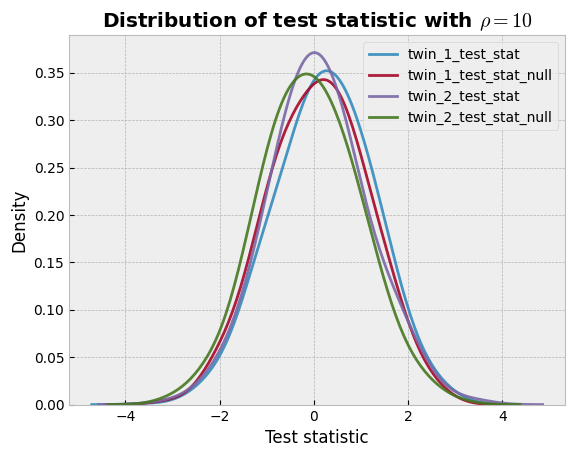

In [100]:
# Compare the distribution

for twin_kw in ["twin_1", "twin_2"]:
    for stat_kw in ["test_stat", "test_stat_null"]:
        temp_data = result_dict[twin_kw][stat_kw]
        sns.kdeplot(
            temp_data,
            fill=False,
            label="_".join([twin_kw, stat_kw]),
            alpha=0.9,
            common_grid=True,
            linewidth=2,
            bw_adjust=1.5,
        )

plt.xlabel("Test statistic")
plt.title(rf"Distribution of test statistic with $\rho={expconfig.rho}$", weight="bold")

plt.legend()
plt.show()

Seed set to 2023
100%|██████████| 1000/1000 [00:10<00:00, 96.25it/s]


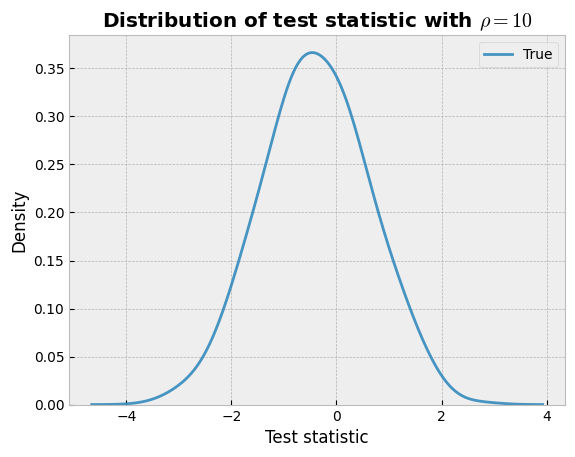

In [101]:
# Distribution of test statistic with true sampler

seed_everything(expconfig.seed)

m = expconfig.rho * expconfig.n_inf
true_sampler = TrueSampler(sigma=expconfig.sigma, null_feature=True)

test_stat_list = []
for d in tqdm(range(expconfig.D)):
    with HiddenPrints():
        temp_df = true_sampler.sample(m, return_df=True)

    test_stat = blackbox_test_stat(
        temp_df,
        model_full,
        model_partial,
        null_feature_names=expconfig.null_features_list,
        **cb_kwargs
    )
    test_stat_list.append(test_stat)

sns.kdeplot(
    test_stat_list,
    label = "True",
    fill=False,
    alpha=0.9,
    linewidth=2,
    bw_adjust=1.5,
)

plt.xlabel("Test statistic")
plt.title(rf"Distribution of test statistic with $\rho={expconfig.rho}$", weight="bold")

plt.legend()
plt.show()

In [8]:
# true test statistic and p value

df_inf = concat_data(expconfig.raw_data_dir, split="val")
raw_test_stat = blackbox_test_stat(
    df_inf,
    model_full,
    model_partial,
    null_feature_names=expconfig.null_features_list,
    **cb_kwargs
)

print("Test statistic from raw sample:", raw_test_stat)

rv = norm()
p_value = 1 - rv.cdf(raw_test_stat)
print("Raw p-value:", p_value)

Test statistic from raw sample: 0.19594580066529502
Raw p-value: 0.42232629415737777


# Syn-Test: Tune Synthetic-to-raw Ratio

In [103]:
# Perform Syn-Test tuning with fine-tuned SYNTHETIC GENERATOR, used for getting m_hat


seed_everything(expconfig.seed)

rho_max, num_rhos = 20, 20

result_dict = {}
for i, rho in enumerate(np.linspace(0, rho_max, num_rhos + 1)[1:]):
    m = int(rho * expconfig.n_inf)
    
    print("-" * 100)
    print(f"rho: {rho}, m: {m}")

    temp_dict = {
        "n_inf": expconfig.n_inf,
        "rho": rho,
        "m": m,
    }
    for twin_kw in ["twin_1", "twin_2"]:
        print("Processing", twin_kw)

        df_twin = df_twin_1 if twin_kw == "twin_1" else df_twin_2
        test_stat_list, test_stat_null_list = [], []
        
        for d in tqdm(range(expconfig.D)):
            temp_df = df_twin.iloc[d * m : (d + 1) * m].copy()
            test_stat = blackbox_test_stat(
                temp_df,
                model_full,
                model_partial,
                null_feature_names=expconfig.null_features_list,
                **cb_kwargs
            )
            test_stat_list.append(test_stat)

            temp_df_null = temp_df.copy()
            temp_df_null[expconfig.null_features_list] = np.random.rand(
                temp_df_null.shape[0], len(expconfig.null_features_list)
            )
            test_stat_null = blackbox_test_stat(
                temp_df_null,
                model_full,
                model_partial,
                null_feature_names=expconfig.null_features_list,
                **cb_kwargs
            )
            test_stat_null_list.append(test_stat_null)

        temp_dict[twin_kw] = {
            "test_stat": test_stat_list,
            "test_stat_null": test_stat_null_list,
        }
    
    result_dict[str(rho)] = temp_dict
    pickle.dump(result_dict, open(expconfig.result_dict_save_path, "wb"))
    
    

Seed set to 2023


----------------------------------------------------------------------------------------------------
rho: 1.0, m: 200
Processing twin_1


100%|██████████| 1000/1000 [00:11<00:00, 88.25it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:11<00:00, 88.60it/s]


----------------------------------------------------------------------------------------------------
rho: 2.0, m: 400
Processing twin_1


100%|██████████| 1000/1000 [00:13<00:00, 73.97it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:13<00:00, 74.01it/s]


----------------------------------------------------------------------------------------------------
rho: 3.0, m: 600
Processing twin_1


100%|██████████| 1000/1000 [00:14<00:00, 67.14it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:14<00:00, 67.42it/s]


----------------------------------------------------------------------------------------------------
rho: 4.0, m: 800
Processing twin_1


100%|██████████| 1000/1000 [00:15<00:00, 65.94it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:15<00:00, 65.72it/s]


----------------------------------------------------------------------------------------------------
rho: 5.0, m: 1000
Processing twin_1


100%|██████████| 1000/1000 [00:15<00:00, 62.52it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:15<00:00, 62.68it/s]


----------------------------------------------------------------------------------------------------
rho: 6.0, m: 1200
Processing twin_1


100%|██████████| 1000/1000 [00:15<00:00, 63.69it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:14<00:00, 67.34it/s]


----------------------------------------------------------------------------------------------------
rho: 7.0, m: 1400
Processing twin_1


100%|██████████| 1000/1000 [00:18<00:00, 55.37it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:18<00:00, 54.90it/s]


----------------------------------------------------------------------------------------------------
rho: 8.0, m: 1600
Processing twin_1


100%|██████████| 1000/1000 [00:18<00:00, 53.93it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:18<00:00, 53.99it/s]


----------------------------------------------------------------------------------------------------
rho: 9.0, m: 1800
Processing twin_1


100%|██████████| 1000/1000 [00:19<00:00, 51.16it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:19<00:00, 51.66it/s]


----------------------------------------------------------------------------------------------------
rho: 10.0, m: 2000
Processing twin_1


100%|██████████| 1000/1000 [00:19<00:00, 51.96it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:19<00:00, 51.68it/s]


----------------------------------------------------------------------------------------------------
rho: 11.0, m: 2200
Processing twin_1


100%|██████████| 1000/1000 [00:19<00:00, 51.34it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:19<00:00, 51.39it/s]


----------------------------------------------------------------------------------------------------
rho: 12.0, m: 2400
Processing twin_1


100%|██████████| 1000/1000 [00:19<00:00, 51.64it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:19<00:00, 51.67it/s]


----------------------------------------------------------------------------------------------------
rho: 13.0, m: 2600
Processing twin_1


100%|██████████| 1000/1000 [00:20<00:00, 49.71it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:20<00:00, 49.92it/s]


----------------------------------------------------------------------------------------------------
rho: 14.0, m: 2800
Processing twin_1


100%|██████████| 1000/1000 [00:20<00:00, 49.34it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:20<00:00, 49.12it/s]


----------------------------------------------------------------------------------------------------
rho: 15.0, m: 3000
Processing twin_1


100%|██████████| 1000/1000 [00:20<00:00, 47.98it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:20<00:00, 48.00it/s]


----------------------------------------------------------------------------------------------------
rho: 16.0, m: 3200
Processing twin_1


100%|██████████| 1000/1000 [00:20<00:00, 48.39it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:20<00:00, 48.67it/s]


----------------------------------------------------------------------------------------------------
rho: 17.0, m: 3400
Processing twin_1


100%|██████████| 1000/1000 [00:20<00:00, 47.62it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:20<00:00, 47.74it/s]


----------------------------------------------------------------------------------------------------
rho: 18.0, m: 3600
Processing twin_1


100%|██████████| 1000/1000 [00:21<00:00, 46.81it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:21<00:00, 46.93it/s]


----------------------------------------------------------------------------------------------------
rho: 19.0, m: 3800
Processing twin_1


100%|██████████| 1000/1000 [00:21<00:00, 45.48it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:22<00:00, 45.45it/s]


----------------------------------------------------------------------------------------------------
rho: 20.0, m: 4000
Processing twin_1


100%|██████████| 1000/1000 [00:22<00:00, 44.74it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:22<00:00, 44.69it/s]


# Syn-Test: Evaluate Results

In [105]:
# Perform Syn-Test tuning with TRUE GENERATOR, used as reference

seed_everything(expconfig.seed)

rho_max, num_rhos = 20, 20
total_size = rho_max * expconfig.n_inf * expconfig.D

true_sampler = TrueSampler(sigma=expconfig.sigma, null_feature=True)
temp_df = true_sampler.sample(2 * total_size, return_df=True)
raw_df_twin_1 = temp_df.iloc[:total_size].copy()
raw_df_twin_2 = temp_df.iloc[total_size:].copy()

raw_result_dict = {}
for i, rho in enumerate(np.linspace(0, rho_max, num_rhos + 1)[1:]):
    m = int(rho * expconfig.n_inf)
    
    print("-" * 100)
    print(f"rho: {rho}, m: {m}")

    temp_dict = {
        "n_inf": expconfig.n_inf,
        "rho": rho,
        "m": m,
    }
    for twin_kw in ["twin_1", "twin_2"]:
        print("Processing", twin_kw)

        df_twin = raw_df_twin_1 if twin_kw == "twin_1" else raw_df_twin_2
        test_stat_list, test_stat_null_list = [], []
        
        for d in tqdm(range(expconfig.D)):
            temp_df = df_twin.iloc[d * m : (d + 1) * m].copy()
            test_stat = blackbox_test_stat(
                temp_df,
                model_full,
                model_partial,
                null_feature_names=expconfig.null_features_list,
                **cb_kwargs
            )
            test_stat_list.append(test_stat)

            temp_df_null = temp_df.copy()
            temp_df_null[expconfig.null_features_list] = np.random.rand(
                temp_df_null.shape[0], len(expconfig.null_features_list)
            )
            test_stat_null = blackbox_test_stat(
                temp_df_null,
                model_full,
                model_partial,
                null_feature_names=expconfig.null_features_list,
                **cb_kwargs
            )
            test_stat_null_list.append(test_stat_null)

        temp_dict[twin_kw] = {
            "test_stat": test_stat_list,
            "test_stat_null": test_stat_null_list,
        }
    
    raw_result_dict[str(rho)] = temp_dict
    pickle.dump(raw_result_dict, open(expconfig.raw_result_dict_save_path, "wb"))
    
    

Seed set to 2023


df shape:  (8000000, 9)
----------------------------------------------------------------------------------------------------
rho: 1.0, m: 200
Processing twin_1


100%|██████████| 1000/1000 [00:08<00:00, 116.87it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:08<00:00, 117.48it/s]


----------------------------------------------------------------------------------------------------
rho: 2.0, m: 400
Processing twin_1


100%|██████████| 1000/1000 [00:11<00:00, 87.07it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:12<00:00, 82.89it/s]


----------------------------------------------------------------------------------------------------
rho: 3.0, m: 600
Processing twin_1


100%|██████████| 1000/1000 [00:13<00:00, 76.09it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:14<00:00, 69.33it/s]


----------------------------------------------------------------------------------------------------
rho: 4.0, m: 800
Processing twin_1


100%|██████████| 1000/1000 [00:14<00:00, 67.56it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:14<00:00, 67.24it/s]


----------------------------------------------------------------------------------------------------
rho: 5.0, m: 1000
Processing twin_1


100%|██████████| 1000/1000 [00:15<00:00, 63.84it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:13<00:00, 75.06it/s]


----------------------------------------------------------------------------------------------------
rho: 6.0, m: 1200
Processing twin_1


100%|██████████| 1000/1000 [00:15<00:00, 65.08it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:15<00:00, 64.76it/s]


----------------------------------------------------------------------------------------------------
rho: 7.0, m: 1400
Processing twin_1


100%|██████████| 1000/1000 [00:17<00:00, 56.54it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:17<00:00, 56.37it/s]


----------------------------------------------------------------------------------------------------
rho: 8.0, m: 1600
Processing twin_1


100%|██████████| 1000/1000 [00:18<00:00, 55.18it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:17<00:00, 55.61it/s]


----------------------------------------------------------------------------------------------------
rho: 9.0, m: 1800
Processing twin_1


100%|██████████| 1000/1000 [00:18<00:00, 52.86it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:19<00:00, 52.58it/s]


----------------------------------------------------------------------------------------------------
rho: 10.0, m: 2000
Processing twin_1


100%|██████████| 1000/1000 [00:19<00:00, 52.06it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:19<00:00, 52.21it/s]


----------------------------------------------------------------------------------------------------
rho: 11.0, m: 2200
Processing twin_1


100%|██████████| 1000/1000 [00:19<00:00, 52.30it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:19<00:00, 52.59it/s]


----------------------------------------------------------------------------------------------------
rho: 12.0, m: 2400
Processing twin_1


100%|██████████| 1000/1000 [00:18<00:00, 52.76it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:18<00:00, 52.92it/s]


----------------------------------------------------------------------------------------------------
rho: 13.0, m: 2600
Processing twin_1


100%|██████████| 1000/1000 [00:19<00:00, 51.21it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:19<00:00, 50.93it/s]


----------------------------------------------------------------------------------------------------
rho: 14.0, m: 2800
Processing twin_1


100%|██████████| 1000/1000 [00:19<00:00, 50.40it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:19<00:00, 50.11it/s]


----------------------------------------------------------------------------------------------------
rho: 15.0, m: 3000
Processing twin_1


100%|██████████| 1000/1000 [00:20<00:00, 49.13it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:20<00:00, 49.14it/s]


----------------------------------------------------------------------------------------------------
rho: 16.0, m: 3200
Processing twin_1


100%|██████████| 1000/1000 [00:20<00:00, 49.43it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:20<00:00, 49.44it/s]


----------------------------------------------------------------------------------------------------
rho: 17.0, m: 3400
Processing twin_1


100%|██████████| 1000/1000 [00:20<00:00, 48.86it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:20<00:00, 49.02it/s]


----------------------------------------------------------------------------------------------------
rho: 18.0, m: 3600
Processing twin_1


100%|██████████| 1000/1000 [00:20<00:00, 47.76it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:20<00:00, 47.87it/s]


----------------------------------------------------------------------------------------------------
rho: 19.0, m: 3800
Processing twin_1


100%|██████████| 1000/1000 [00:21<00:00, 46.33it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:20<00:00, 47.86it/s]


----------------------------------------------------------------------------------------------------
rho: 20.0, m: 4000
Processing twin_1


100%|██████████| 1000/1000 [00:21<00:00, 47.30it/s]


Processing twin_2


100%|██████████| 1000/1000 [00:21<00:00, 46.24it/s]


In [9]:
result_dict = pickle.load(open(expconfig.result_dict_save_path, "rb"))
rho_list, type_i_error_list, p_values_combined = soft_type_i_errors(
    result_dict, alpha=expconfig.alpha, epsilon=expconfig.epsilon
)

raw_result_dict = pickle.load(open(expconfig.raw_result_dict_save_path, "rb"))
_, raw_type_i_error_list, raw_p_values_combined = soft_type_i_errors(
    raw_result_dict, alpha=expconfig.alpha, epsilon=0
)

Text(0.5, 1.0, 'Syn-Test on null feature $X_8$: Type-I error curve')

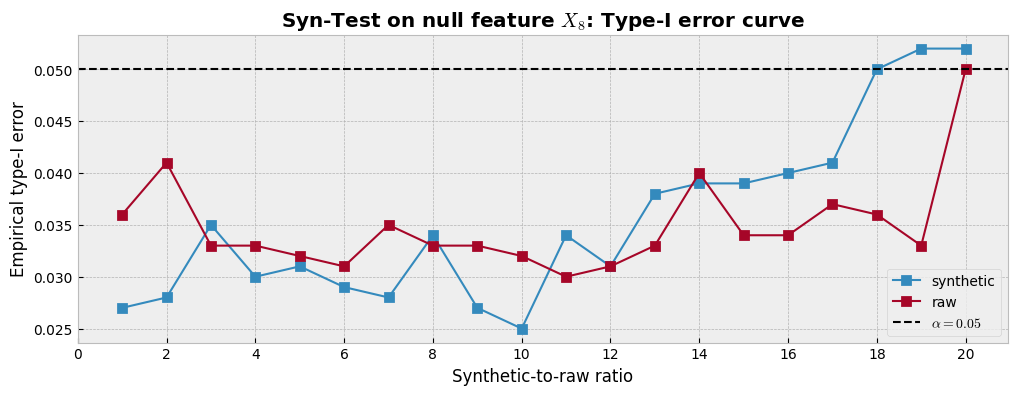

In [10]:
# Visualize Syn-Test tuning curve

plt.style.use("bmh")

plt.figure(figsize=(12, 4))

plt_kwargs = {
    "marker": "s",
    "mew": 2,
    "linestyle": "-",
    "markersize": 6,
    "linewidth": 1.5,
}

plt.plot(rho_list, type_i_error_list, label="synthetic", **plt_kwargs)
plt.plot(rho_list, raw_type_i_error_list, label="raw", **plt_kwargs)

plt.axhline(
    expconfig.alpha,
    linestyle="--",
    color="black",
    linewidth=plt_kwargs["linewidth"],
    label=r"$\alpha=0.05$",
)

plt.legend()

plt.xticks(ticks=np.arange(0, 21, 2))
plt.xlabel("Synthetic-to-raw ratio")


plt.ylabel("Empirical type-I error")

plt.title(r"Syn-Test on null feature $X_8$: Type-I error curve", fontweight="bold")

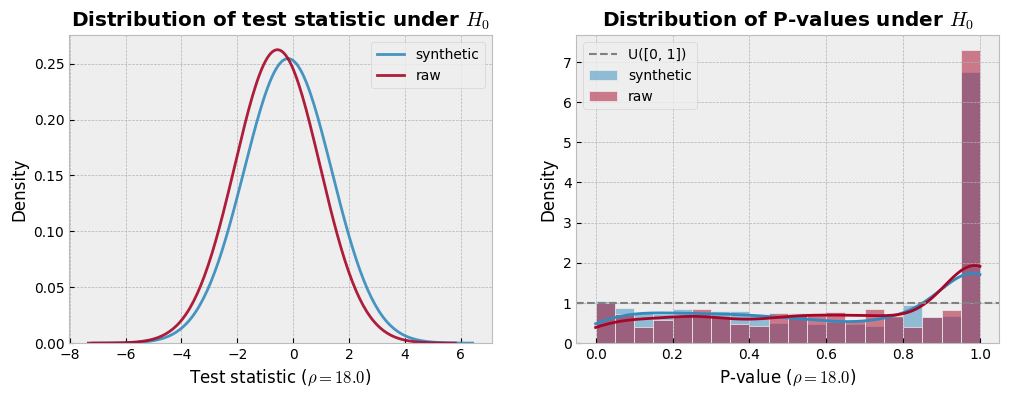

In [11]:
# Estimated null distribution and p-values from Syn-Test

rho_best = 18.0
plt_kwargs = {
    "sb1": {
        "fill": False,
        "alpha": 0.9,
        "common_grid": True,
        "linewidth": 2,
        "bw_adjust": 5,
    },
    "sb2": {
        "stat": "density",
        "bins": 20,
        "kde": True,
        "alpha": 0.5,
        "common_bins": True,
    },
}

p_values_combined_adjust = np.array(
    [
        p + expconfig.epsilon
        if p >= expconfig.alpha - expconfig.epsilon and p <= expconfig.alpha
        else p
        for p in p_values_combined
    ]
)


fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs = axs.ravel()

# Syn-Test tuning curve with reference
sns.kdeplot(
    result_dict[str(rho_best)]["twin_2"]["test_stat_null"],
    label="synthetic",
    ax=axs[0],
    **plt_kwargs["sb1"],
)
sns.kdeplot(
    raw_result_dict[str(rho_best)]["twin_2"]["test_stat_null"],
    label="raw",
    ax=axs[0],
    **plt_kwargs["sb1"],
)

axs[0].set_xlabel(rf"Test statistic ($\rho={rho_best}$)")
axs[0].set_title(
    rf"Distribution of test statistic under $H_0$", weight="bold"
)
axs[0].legend()

# Estimated distribution of test stat and distribution of p-value, with reference
sns.histplot(
    p_values_combined_adjust, label="synthetic", ax=axs[1], **plt_kwargs["sb2"]
)
sns.histplot(raw_p_values_combined, label="raw", ax=axs[1], **plt_kwargs["sb2"])
axs[1].axhline(y=1, linestyle="--", color="grey", linewidth=1.5, label="U([0, 1])")
axs[1].set_xlabel(rf"P-value ($\rho={rho_best}$)")
axs[1].set_title(rf"Distribution of P-values under $H_0$", weight="bold")
axs[1].legend()


plt.show()

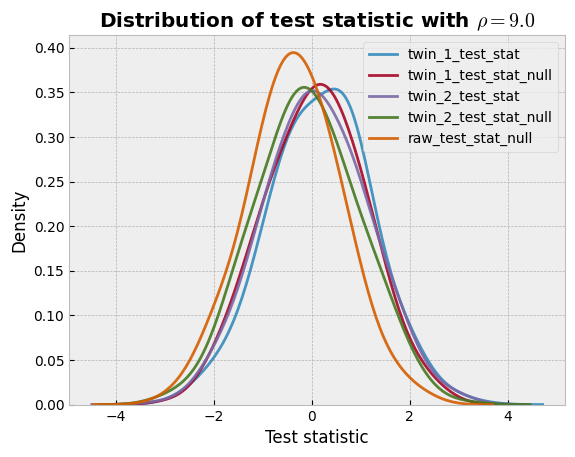

In [12]:
# Visualize distributions of null synthetic versus synthetic for the null feature

rho_best = 9.0

kde_kwargs = {
    "fill": False,
    "alpha": 0.9,
    "common_grid": True,
    "linewidth": 2,
    "bw_adjust": 1.5,
}

for twin_kw in ["twin_1", "twin_2"]:
    for stat_kw in ["test_stat", "test_stat_null"]:
        temp_data = result_dict[str(rho_best)][twin_kw][stat_kw]
        sns.kdeplot(
            temp_data,
            label="_".join([twin_kw, stat_kw]),
            **kde_kwargs,
        )

sns.kdeplot(
    raw_result_dict[str(rho_best)]["twin_1"]["test_stat_null"],
    label="raw_test_stat_null",
    **kde_kwargs,
)

plt.xlabel("Test statistic")
plt.title(rf"Distribution of test statistic with $\rho={rho_best}$", weight="bold")

plt.legend()
plt.show()

# 2-Wasserstein distances of trained/fine-tuned TDMs

In [116]:
seed_everything(expconfig.seed)

# True data from the true generator
true_sampler = TrueSampler(sigma=expconfig.sigma, null_feature=True)
df_true = true_sampler.sample(n=10000, return_df=True)

# Synthetic data from the pre-trained generator
generate_sample(
    pipeline_config_path=f"{expconfig.ckpt_dir}/config.toml",
    ckpt_path=f"{expconfig.ckpt_dir}/model.pt",
    num_samples=10000,
    batch_size=10000,
    temp_parent_dir=expconfig.cache_dir,
    device=f"cuda:{expconfig.cuda_id}",
    seed=random.randint(0, 100000),
)
df_pretrain = concat_data(expconfig.cache_dir, split="train")

# Synthetic data from the fine-tuned generator
twin_kw = "twin_1"
generate_sample(
    pipeline_config_path=f"./ckpt/{expconfig.keyword}_{twin_kw}/config.toml",
    ckpt_path=f"./ckpt/{expconfig.keyword}_{twin_kw}/model.pt",
    pipeline_dict_path=f"{expconfig.ckpt_dir}/pipeline_dict.joblib",
    num_samples=10000,
    batch_size=10000,
    temp_parent_dir=expconfig.cache_dir,
    device=f"cuda:{expconfig.cuda_id}",
    seed=random.randint(0, 100000),
)
df_finetune = concat_data(expconfig.cache_dir, split="train")

Seed set to 2023


df shape:  (10000, 9)
Use category sizes from the training set: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (10000, 8)
Loading numerical preprocessing pipeline from ./ckpt/inf_10000/pipeline_dict.joblib
Use category sizes from the loaded pipeline: [0]
mlp
Sample timestep    0
Discrete cols: []
Num shape:  (10000, 8)


In [117]:
w2_pretrain = wasserstein_2_distance(df_pretrain, df_true)
print("2-Wasserstein distance between pre-trained synthetic and true:", w2_pretrain)

w2_finetune = wasserstein_2_distance(df_finetune, df_true)
print("2-Wasserstein distance between fine-tuned synthetic and true:", w2_finetune)

2-Wasserstein distance between pre-trained synthetic and true: 0.32054096448038555
2-Wasserstein distance between fine-tuned synthetic and true: 0.33543926527603146
